In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
data = pd.concat([train, test])

## Initial Exploration of data set

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [4]:
# missing values from each columns
data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
data.describe().loc[['count', 'mean', 'min', 'max']]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.0,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.0,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
min,1.0,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
max,1309.0,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


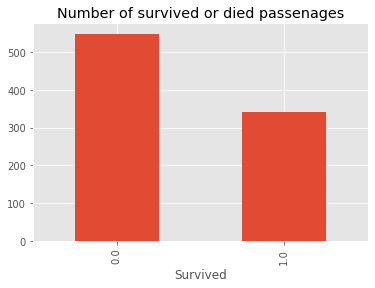

In [6]:
pd.pivot_table(data, values='PassengerId', index='Survived', aggfunc='count').plot(kind='bar', legend = False, title = 'Number of survived or died passenages')
plt.show()

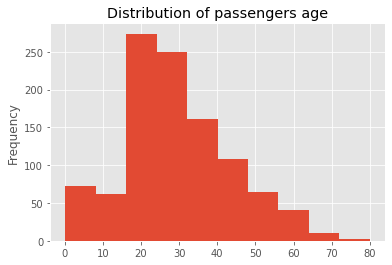

In [7]:
data['Age'].plot(kind='hist', title = 'Distribution of passengers age')
plt.show()

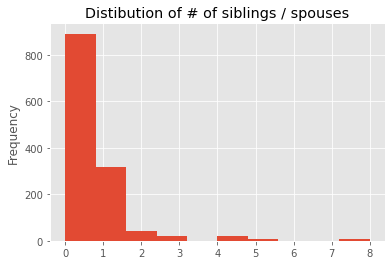

In [8]:
data['SibSp'].plot(kind='hist', title='Distibution of # of siblings / spouses')
plt.show()

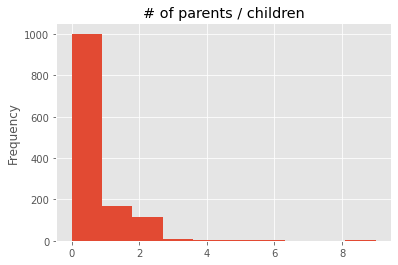

In [9]:
data['Parch'].plot(kind='hist', title='# of parents / children')
plt.show()

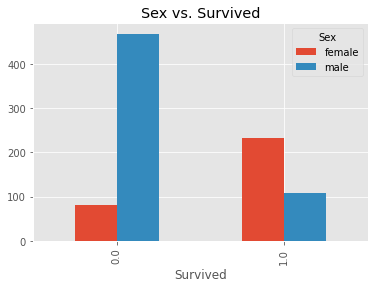

In [10]:
pd.pivot_table(data, values='PassengerId', index='Survived', columns='Sex', aggfunc='count').plot(kind='bar', title='Sex vs. Survived')
plt.show()

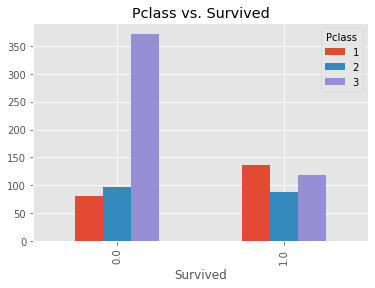

In [11]:
pd.pivot_table(data, values='PassengerId', index='Survived', columns='Pclass', aggfunc='count').plot(kind='bar', title='Pclass vs. Survived')
plt.show()

In [12]:
data['Age_bins'] = pd.cut(data['Age'], bins = [0, 11, 24, 50, 78, 100], labels = ['children', 'youth', 'youth_adults', 'mid_age_adults', 'elderly'])

<AxesSubplot:title={'center':'Age vs. Survived'}, xlabel='Survived'>

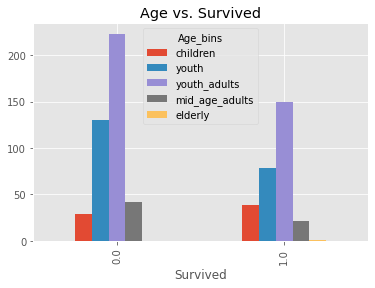

In [13]:
pd.pivot_table(data, index='Survived', columns='Age_bins', values='PassengerId', aggfunc='count').plot(kind='bar', title='Age vs. Survived')

# Split the train and test set

In [14]:
X_train = data.loc[data['Survived'].notna()].drop('Survived', axis=1)
y_train = data.loc[data['Survived'].notna()]['Survived']
X_test = data.loc[data['Survived'].isna()].drop('Survived', axis=1)

# Feature Enginnering
1. Extract titles of names and group them properly 
2. One hot encoding the categorical features (title, embarked, sex)

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class Feature_Enginnering(BaseEstimator, TransformerMixin):
    def __init__(self, feature = 'Name', features_selected = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']):
        self.feature = feature
        self.features_selected = features_selected
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        
        # extract title from name
        X_['Title'] = X_[self.feature].apply(lambda x: x.split(',')[1].split('.')[0].strip())
        X_.loc[X_['Title'] == 'Mlle', 'Title'] = 'Miss'
        X_.loc[X_['Title'] == 'Mme', 'Title'] = 'Mrs'
        X_.loc[X_['Title'] == 'Dona', 'Title'] = 'Mrs'
        X_.loc[X_['Title'] == 'Lady', 'Title'] = 'Ms'
        X_.loc[X_['Title'].isin(['Don', 'Sir']), 'Title'] = 'Mr'
        X_.loc[X_['Title'].isin(['Major', 'Col', 'Capt']), 'Title'] = 'Mr'
        X_.loc[X_['Title'].isin(['the Countess', 'Jonkheer']), 'Title'] = 'Mr'
        X_['Fare'].fillna(X_['Fare'].median())
        # One-Hot-Encoder
        X_ = pd.get_dummies(X_[self.features_selected])
        sc = MinMaxScaler()
        X_ = sc.fit_transform(X_)
        return X_

In [16]:
print('Shape_X_train: {}'.format(X_train.shape))
print('Shape_y_train: {}'.format(y_train.shape))
print('Shape_X_test: {}'.format(X_test.shape))

Shape_X_train: (891, 12)
Shape_y_train: (891,)
Shape_X_test: (418, 12)


In [17]:
# fit_transform train set, and transform test set
fe = Feature_Enginnering()
X_train = fe.fit_transform(X_train)
X_test = fe.transform(X_test)

# Model selection

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier

classifer_name = ['RandomForest', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'XGBoostClassifer']
classifier = {
    'RandomForest': RandomForestClassifier(random_state = 1),
    'AdaBoostClassifier': AdaBoostClassifier(random_state = 1),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = 1),
    'XGBoostClassifer': XGBClassifier(random_state = 1)
}

acc = []

for name in classifer_name:
    pipe = make_pipeline(KNNImputer(n_neighbors=5), classifier[name])
    acc.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

pd.DataFrame({'Classifer': classifer_name, 'Accuracy': acc}).sort_values(by='Accuracy', ascending=False)

[01:47:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:47:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:47:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:47:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Classifer,Accuracy
1,AdaBoostClassifier,0.827217
2,GradientBoostingClassifier,0.821562
3,XGBoostClassifer,0.817080
0,RandomForest,0.802473


# Hyperparameters tuning for AdaBoostClassifier

In [19]:
pipe = make_pipeline(KNNImputer(), AdaBoostClassifier(random_state = 1))
pipe.get_params()

{'memory': None,
 'steps': [('knnimputer', KNNImputer()),
  ('adaboostclassifier', AdaBoostClassifier(random_state=1))],
 'verbose': False,
 'knnimputer': KNNImputer(),
 'adaboostclassifier': AdaBoostClassifier(random_state=1),
 'knnimputer__add_indicator': False,
 'knnimputer__copy': True,
 'knnimputer__metric': 'nan_euclidean',
 'knnimputer__missing_values': nan,
 'knnimputer__n_neighbors': 5,
 'knnimputer__weights': 'uniform',
 'adaboostclassifier__algorithm': 'SAMME.R',
 'adaboostclassifier__base_estimator': None,
 'adaboostclassifier__learning_rate': 1.0,
 'adaboostclassifier__n_estimators': 50,
 'adaboostclassifier__random_state': 1}

In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

parameters = {
    'knnimputer__n_neighbors': [5, 11, 15],
    'adaboostclassifier__n_estimators': [100, 500, 1000],
    'adaboostclassifier__learning_rate': [0.01, 0.05, 0.1, 0.3]
}

pipe = make_pipeline(KNNImputer(), AdaBoostClassifier(random_state = 1))
clf = RandomizedSearchCV(estimator=pipe, param_distributions = parameters)
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                             ('adaboostclassifier',
                                              AdaBoostClassifier(random_state=1))]),
                   param_distributions={'adaboostclassifier__learning_rate': [0.01,
                                                                              0.05,
                                                                              0.1,
                                                                              0.3],
                                        'adaboostclassifier__n_estimators': [100,
                                                                             500,
                                                                             1000],
                                        'knnimputer__n_neighbors': [5, 11, 15]})

In [21]:
clf.best_params_

{'knnimputer__n_neighbors': 5,
 'adaboostclassifier__n_estimators': 1000,
 'adaboostclassifier__learning_rate': 0.3}

In [22]:
adb = AdaBoostClassifier(learning_rate=0.3, n_estimators = 1000)
pipe = make_pipeline(KNNImputer(n_neighbors=11), adb)
cross_val_score(pipe, X_train, y_train, cv = 5, scoring = 'accuracy').mean()

0.8260686711443098

In [23]:
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

In [24]:
results = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': pred.astype('int')})
results

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [25]:
results.to_csv('results.csv', index=False)